#Q1: Probabilistic N-Gram Language Model(50 points)

**Objective:**

The objective of this question is to implement and experiment with an N-Gram language model using the Reuters dataset. The task involves building a probabilistic N-Gram model and creating a text generator based on the trained model with customizable parameters.

**Tasks:**


**1.Text Preprocessing (5 points):**
*   Implement the preprocess_text function to perform necessary text preprocessing. You may use NLTK or other relevant libraries for this task. (Already provided, no modification needed)


**2.Build Probabilistic N-Gram Model (15 points):**

*   Implement the build_probabilistic_ngram_model function to construct a probabilistic N-Gram model from the Reuters dataset.


**3.Generate Text with Customizable Parameters (15 points):**

*   Implement the generate_text function to generate text given a seed text and the probabilistic N-Gram model.
*   The function should have parameters for probability_threshold and min_length to customize the generation process.
*   Ensure that the generation stops when either the specified min_length is reached or the probabilities fall below probability_threshold.


**4.Experimentation and Parameter Tuning (5 points):**

*   Use Google Colab to experiment with different values of n_value, probability_threshold, and min_length.
Find the optimal parameters that result in coherent and meaningful generated text.
*   Provide a detailed analysis of the impact of changing each parameter on the generated text's quality.
*   Discuss any challenges faced during parameter tuning and propose potential improvements.


**5.Results and Conclusion (10 points):**

*   Summarize your findings and present the optimal parameter values for n_value, probability_threshold, and min_length.
*   Discuss the trade-offs and considerations when selecting these parameters.
*   Conclude with insights gained from the experimentation.

In [ ]:
import nltk
from nltk.corpus import reuters
from nltk import ngrams
from nltk.tokenize import word_tokenize, sent_tokenize
import random
import string
from collections import Counter, defaultdict
from itertools import chain

# Download the Reuters dataset if not already downloaded
nltk.download('reuters')
nltk.download('punkt')

[nltk_data] Downloading package reuters to /root/nltk_data...
[nltk_data]   Package reuters is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
# Function to preprocess text
def preprocess_text(text):
    # Remove case sensitivity
    text = text.lower()

    # Remove title of text
    text = text.split('\n', maxsplit=1)[1]

    # Sentence tokenization
    sentences = sent_tokenize(text)

    processed_sentences = []
    for sentence in sentences:
        # Tokenization
        tokens = word_tokenize(sentence)

        # Remove tokens that are entirely punctuation
        tokens = [token for token in tokens if token.isalnum() or not all(char in string.punctuation for char in token)]

        # Add special token for end of the sentence
        processed_sentence = tokens + ['</s>']

        # Add sentence to gathered tokens
        processed_sentences.extend(processed_sentence)

    return processed_sentences

In [ ]:
# Function to build a probabilistic n-gram model
def build_probabilistic_ngram_model(corpus, n):
    # Flatten corpus to a 1D list of tokens
    tokens = list(chain.from_iterable(corpus))

    # For storing n-gram probabilities
    n_gram_probabilities = defaultdict(lambda: defaultdict(float))

    # Create ngram list for all values in [1, n]
    for i in range(1, n + 1):
        # Generate n-grams from tokens
        i_grams = ngrams(tokens, i)

        # Count n-grams in the corpus
        i_gram_counts = Counter(i_grams)

        # Printing number of i-grams in corpus
        print(f'Number of {i}-grams: {len(list(i_gram_counts))}')

        # If n is 1, we're dealing with unigrams, which are a special case
        if i == 1:
            total_unigrams = sum(i_gram_counts.values())
            for unigram, count in i_gram_counts.items():
                n_gram_probabilities[unigram[0]] = count / total_unigrams
        else:
            # Generate (n-1)-grams for denominator in probability calculation
            i_minus_1_grams = ngrams(tokens, i-1)
            i_minus_1_gram_counts = Counter(i_minus_1_grams)

            # Calculate probabilities for n-grams
            for n_gram, count in i_gram_counts.items():
                prefix = n_gram[:-1]
                n_gram_probabilities[prefix][n_gram[-1]] = count / i_minus_1_gram_counts[prefix]

    return n_gram_probabilities

In [ ]:
# Function to generate text using the probabilistic n-gram model with stop criteria on min_length and tokens' probabilities
# Also added a custom parameter to end the generation when the end_token </s> is observed
def generate_text(model, unigram_model, seed_text, n, probability_threshold=0.1, min_length=10, exit_on_end_token=False):
    generated_text = seed_text.lower()  # Initialize generated text with seed text
    generated_text_prob = 1             # Store generated text probaility
    generated_text_gram = []            # Store generated text n-grams used
    generated_text_tokens_probs = []    # Store tokens and their probabilities used in generated text

    while True:
        # Check if minimum length requirement is met
        if exit_on_end_token and '</s>' in generated_text:
            break
        # Check if end_token is appeared in text (Custom added criteria)
        if len(generated_text.split()) >= min_length and not exit_on_end_token:
            break

        generated_tokens = generated_text.split()

        # Get the last n-1 words as prefix, and if the text is smaller, choose its tokens' length
        m = min(n-1, len(generated_tokens))

        # Check until one prefix is found. Decreament m in each round
        prefix_found = False
        while not prefix_found and m > 0:
            prefix = tuple(generated_tokens[-m:])
            if prefix in model:
                prefix_found = True
                break
            m -= 1

        generated_text_gram.append(m + 1)

        # Check if prefix exists in the model
        if prefix_found:
            next_word_probs = model[prefix]
            # Filter next word probabilities based on probability threshold
            filtered_probs = {word: prob for word, prob in next_word_probs.items() if prob >= probability_threshold}
        else:
            # Filter next word probabilities based on probability threshold
            filtered_probs = {word: prob for word, prob in unigram_model.items() if prob >= probability_threshold}

        # Check if any words meet the probability threshold
        if filtered_probs:
            # Choose the next word based on probabilities
            next_word = random.choices(list(filtered_probs.keys()), weights=filtered_probs.values())[0]
            generated_text_prob *= filtered_probs[next_word]
            generated_text_tokens_probs.append((next_word, filtered_probs[next_word]))
            generated_text += (' ' + next_word)
        else:
            break  # Stop if no words meet the probability threshold

    # Return genereated_text and its probability and n-grams that have been used for its construction
    return generated_text, generated_text_prob, generated_text_gram, generated_text_tokens_probs

In [ ]:
def clean_generated_text(generated_text):
    # Replace end token with period
    if ' </s>' in generated_text:
        generated_text = generated_text.replace(' </s>', '.')

    # Capitalized sentence
    return generated_text.capitalize()

In [ ]:
# Load the Reuters dataset
corpus = [reuters.raw(file_id) for file_id in reuters.fileids()]

# Preprocess the entire corpus
preprocessed_corpus = [preprocess_text(text) for text in corpus]

In [ ]:
# Searching Hyperparameter space using RandomSearch
probability_threshold_list = [0.005, 0.01, 0.03, 0.09, 0.1]
min_length_list = [5, 10, 15, 20, 25, 30, 35, 40]
n_value_list = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
iterations = 300

# Build the probabilistic n-gram model
n_value = max(n_value_list)
max_length = max(min_length_list)
probabilistic_ngram_model = build_probabilistic_ngram_model(preprocessed_corpus, n_value)

Number of 1-grams: 48940
Number of 2-grams: 388950
Number of 3-grams: 839742
Number of 4-grams: 1094469
Number of 5-grams: 1207375
Number of 6-grams: 1255802
Number of 7-grams: 1278749
Number of 8-grams: 1291013
Number of 9-grams: 1298057
Number of 10-grams: 1302696


In [ ]:
unigram_model = {k: v for k, v in probabilistic_ngram_model.items() if isinstance(k, str)}

In [ ]:
# An example of output from generated_text function
seed_text = "Inflation is"
generated_text, generated_text_prob, generated_text_gram, generated_text_tokens_probs = generate_text(probabilistic_ngram_model, unigram_model, seed_text, 4, probability_threshold=0.02, min_length=10)
print(f"Generated Text: {generated_text}")
print(f"Generated Text Probability: {generated_text_prob}")
print(f"Generated Text n-grams:", generated_text_gram)
print(f"Generated Text Tokens:", generated_text_tokens_probs)

Generated Text: inflation is for february </s> total gold and currency reserves
Generated Text Probability: 0.0029629629629629624
Generated Text n-grams: [3, 4, 4, 4, 4, 4, 4, 4]
Generated Text Tokens: [('for', 0.06666666666666667), ('february', 1.0), ('</s>', 1.0), ('total', 0.3333333333333333), ('gold', 0.6666666666666666), ('and', 1.0), ('currency', 0.2), ('reserves', 1.0)]


In [ ]:
# Test the text generator and find best setting
seed_text = "Inflation is"

best_score = float('-inf')  # Assuming higher score is better
max_length = max(min_length_list)

scores = defaultdict(float)
min_length = 15

# Random serach on hyperparameter space
for i in range(iterations):
    # Randomly select a value for each hyperparameter
    n = random.choice(n_value_list)
    p = random.choice(probability_threshold_list)

    total_prob = 0
    j = 0
    k = 10
    while j < 3 and k > 0:
        # Generate text with current set of hyperparameters
        generated_text, generated_text_prob, _, _ = generate_text(probabilistic_ngram_model, unigram_model, seed_text, n, probability_threshold=p, min_length=min_length)

        # Normalize value according to length of text generated compared to max min_length
        if len(generated_text.split()) == min_length:
            total_prob += generated_text_prob / len(generated_text)
            j += 1
        else:
            k -= 1
    if k == 0:
        print(f"\t{i + 1} --- Skipped")
        continue

    # Get the average of normalized probabilities
    score = total_prob / 3

    print(f"\t{i + 1} --- With Setting: n_value={n}, probability_threshold={p}, with average_score={score}")

    # Update scores
    scores[(n, p)] = score

	1 --- Skipped
	2 --- With Setting: n_value=6, probability_threshold=0.09, with average_score=0.00028845505394778896
	3 --- Skipped
	4 --- With Setting: n_value=10, probability_threshold=0.01, with average_score=0.0008545018101502413
	5 --- Skipped
	6 --- With Setting: n_value=4, probability_threshold=0.01, with average_score=9.487230307353563e-08
	7 --- With Setting: n_value=10, probability_threshold=0.01, with average_score=0.0009243729196596438
	8 --- With Setting: n_value=10, probability_threshold=0.01, with average_score=0.0008276089284243474
	9 --- With Setting: n_value=4, probability_threshold=0.1, with average_score=1.9881062992906231e-07
	10 --- With Setting: n_value=10, probability_threshold=0.1, with average_score=0.0008843760235833606
	11 --- With Setting: n_value=7, probability_threshold=0.03, with average_score=0.0009062614026922917
	12 --- With Setting: n_value=5, probability_threshold=0.1, with average_score=0.0002571786525274897
	13 --- With Setting: n_value=9, probabi

In [ ]:
best_5 = sorted(scores, key=scores.get, reverse=True)[:5]
worst_5 = sorted(scores, key=scores.get, reverse=True)[-5:]

print(f"Best 5 settings: {best_5}")
print(f"Worst 5 settings: {worst_5}")

Best 5 settings: [(10, 0.03), (7, 0.03), (9, 0.01), (10, 0.005), (9, 0.005)]
Worst 5 settings: [(2, 0.01), (1, 0.03), (2, 0.005), (1, 0.01), (1, 0.005)]


In [ ]:
for n, p in best_5:
    print(f"With Setting: n_value={n}, probability_threshold={p}:")
    for i in range(2):
        print(f'\t{i}th Test:')
        generated_text, generated_text_prob, generated_text_gram, generated_text_tokens_probs = generate_text(probabilistic_ngram_model, unigram_model, seed_text, 4, probability_threshold=0.02, min_length=10, exit_on_end_token=True)
        generated_text = clean_generated_text(generated_text)
        print(f"\t\tGenerated Text: {generated_text}")
        print(f"\t\tGenerated Text Probability: {generated_text_prob}")
        print(f"\t\tGenerated Text n-grams:", generated_text_gram)
        print(f"\t\tGenerated Text Tokens:", generated_text_tokens_probs)

With Setting: n_value=10, probability_threshold=0.005:
	0th Test:
		Generated Text: Inflation is not as worried as it was 18 months ago have now brought currencies within ranges that better reflected economic fundamentals he said adding the move to price other countries natural resources according to the bank by making a sizeable increase in the quota agreement said one major u.s. roaster.
		Generated Text Probability: 2.9050515732643776e-14
		Generated Text n-grams: [3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]
		Generated Text Tokens: [('not', 0.2), ('as', 0.6666666666666666), ('worried', 0.25), ('as', 1.0), ('it', 1.0), ('was', 1.0), ('18', 0.4), ('months', 1.0), ('ago', 1.0), ('have', 0.08333333333333333), ('now', 0.5), ('brought', 1.0), ('currencies', 1.0), ('within', 1.0), ('ranges', 1.0), ('that', 0.5), ('better', 0.6666666666666666), ('reflected', 0.3333333333333333), ('econ

In [ ]:
for n, p in worst_5:
    print(f"With Setting: n_value={n}, probability_threshold={p}:")
    for i in range(2):
        print(f'\t{i}th Test:')
        generated_text, generated_text_prob, generated_text_gram, generated_text_tokens_probs = generate_text(probabilistic_ngram_model, unigram_model, seed_text, 4, probability_threshold=0.02, min_length=10, exit_on_end_token=True)
        generated_text = clean_generated_text(generated_text)
        print(f"\t\tGenerated Text: {generated_text}")
        print(f"\t\tGenerated Text Probability: {generated_text_prob}")
        print(f"\t\tGenerated Text n-grams:", generated_text_gram)
        print(f"\t\tGenerated Text Tokens:", generated_text_tokens_probs)

With Setting: n_value=2, probability_threshold=0.01:
	0th Test:
		Generated Text: Inflation is a real risk from protectionist lobbies particularly in the consumer banking sector a chase manhattan official said.
		Generated Text Probability: 0.00017094017094017097
		Generated Text n-grams: [3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]
		Generated Text Tokens: [('a', 0.06666666666666667), ('real', 1.0), ('risk', 0.2), ('from', 1.0), ('protectionist', 1.0), ('lobbies', 1.0), ('particularly', 1.0), ('in', 1.0), ('the', 1.0), ('consumer', 0.07692307692307693), ('banking', 0.16666666666666666), ('sector', 1.0), ('a', 1.0), ('chase', 1.0), ('manhattan', 1.0), ('official', 1.0), ('said', 1.0), ('</s>', 1.0)]
	1th Test:
		Generated Text: Inflation is expected to produce 10,000 ounces of gold 966,266 ounces of silver 45.5 mln lbs of edible products and 5.4 mln lbs of edible products during february the census bureau said.
		Generated Text Probability: 4.73168255906351e-10
		Generated Te

In [ ]:
# Test the text generator and find best setting
seed_text = "Inflation is"

best_score = float('-inf')  # Assuming higher score is better

scores = defaultdict(float)

# Random serach on hyperparameter space
for n, p in best_5:
    for l in min_length_list:
        total_prob = 0
        j = 0
        k = 10
        while j < 3 and k > 0:
            # Generate text with current set of hyperparameters
            generated_text, generated_text_prob, _, _ = generate_text(probabilistic_ngram_model, unigram_model, seed_text, n, probability_threshold=p, min_length=l)

            # Normalize value according to length of text generated compared to max min_length
            if len(generated_text.split()) == l:
                total_prob += generated_text_prob / len(generated_text)
                j += 1
            else:
                k -= 1
        if k == 0:
            continue

        # Get the average of normalized probabilities
        score = total_prob / 3

        print(f"\t--- With Setting: n_value={n}, probability_threshold={p}, min_length={l}, with average_score={score}")

        # Update scores
        scores[(n, p, l)] = score

	--- With Setting: n_value=10, probability_threshold=0.03, min_length=5, with average_score=0.0025871679544842963
	--- With Setting: n_value=10, probability_threshold=0.03, min_length=10, with average_score=0.0011592887399339013
	--- With Setting: n_value=10, probability_threshold=0.03, min_length=15, with average_score=0.0007809204553390599
	--- With Setting: n_value=10, probability_threshold=0.03, min_length=20, with average_score=0.0006230529595015577
	--- With Setting: n_value=10, probability_threshold=0.03, min_length=25, with average_score=0.0004991331046363123
	--- With Setting: n_value=10, probability_threshold=0.03, min_length=30, with average_score=0.0003776803118908382
	--- With Setting: n_value=10, probability_threshold=0.03, min_length=35, with average_score=0.0003331692839992245
	--- With Setting: n_value=10, probability_threshold=0.03, min_length=40, with average_score=0.00030133948530858235
	--- With Setting: n_value=7, probability_threshold=0.03, min_length=5, with ave

In [ ]:
best_5 = sorted(scores, key=scores.get, reverse=True)[:5]
worst_5 = sorted(scores, key=scores.get, reverse=True)[-5:]

print(f"Best 5 settings: {best_5}")
print(f"Worst 5 settings: {worst_5}")

Best 5 settings: [(9, 0.005, 5), (7, 0.03, 5), (9, 0.01, 5), (10, 0.03, 5), (10, 0.005, 5)]
Worst 5 settings: [(9, 0.01, 40), (7, 0.03, 30), (9, 0.01, 30), (7, 0.03, 35), (7, 0.03, 40)]


### Analysis and Improvement
So using the RandomSearch we can find out following:

- n_value: The higher it is the more likely it is to generate a good, human-readable text. It's beacause of the fact that with higher n-gram, we take in more history into our calculations.
- min_length: with less number of value for this parameter we can get better result because the generation of text will have to rely more on the model predictions.
- probability_threshold: A value not that big and not that small works best. Because if it's too high then, out generation would become greedy, otherwise it just doesn't generate well texts with contributing words with low probabilities

#Q2: Sentiment Analysis with Naive Bayes Classifier(50 Points)

**Objective:**

You are tasked with implementing a Naive Bayes classifier for sentiment analysis. The provided code is incomplete, and your goal is to complete the missing parts. Additionally, you should train the classifier on a small dataset and analyze its performance.

**Tasks:**

1.**Complete the Code (35 points)**: Fill in the missing parts in the provided Python code for the Naive Bayes classifier. Pay special attention to the `extract_features` function.

2.**Train and Test**: Train the Naive Bayes classifier on the training data and test it on a separate test set. Evaluate the accuracy of the classifier.

3.**Analysis (15 points)**: Discuss the results. Identify any misclassifications and try to understand why the classifier may fail in those cases. Provide examples of sentences that were not predicted correctly and explain possible reasons.


In [8]:
import random
import math
import string
from collections import defaultdict, Counter
import numpy as np

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.corpus import movie_reviews
import nltk
import matplotlib.pyplot as plt

# Download NLTK resources
nltk.download('movie_reviews')
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [9]:
def get_features(tokens):
    # Remove punctuation
    tokens = [word for word in tokens if word not in string.punctuation]

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word.lower() not in stop_words]

    # Perform stemming
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(word) for word in tokens]

    return tokens

In [11]:
def plot_result(x, y, x_label, y_label, title):
    plt.figure(figsize=(10, 5))
    plt.bar(x, y)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.xticks(rotation=90)
    plt.show()
    print()

In [10]:
class NaiveBayesClassifier:
    def __init__(self, classes):
        self.classes = classes
        self.class_probs = defaultdict(float)
        self.feature_probs = defaultdict(lambda: defaultdict(float))

    def train(self, training_data):
        class_counts = defaultdict(int)         # For storing class counts
        feature_counts = defaultdict(lambda: defaultdict(int))  # For storing feature counts in each class
        total_counts = 0      # For storing all features

        # Counting number of each of tokens in classes
        for tokens, c in training_data:
            class_counts[c] += 1
            for f in tokens:
                feature_counts[f][c] += 1
            total_counts += 1

        # Calculating probability of each class
        for c in self.classes:
            self.class_probs[c] = np.log(class_counts[c]/total_counts)

        # Calculating probability of each feature
        for f, c_count in feature_counts.items():
            for c in self.classes:
                self.feature_probs[f][c] = np.log((c_count[c] + 1)/(class_counts[c]+len(feature_counts)))

    def classify(self, features):
        class_likelihood = defaultdict(float)   # For storing class likelihoods for given features
        for c in self.classes:
            class_likelihood[c] = self.class_probs[c]
            for f in features:
                if f in self.feature_probs:
                    class_likelihood[c] += self.feature_probs[f][c]
        return max(class_likelihood, key=class_likelihood.get)

In [26]:
# Load the movie reviews dataset from NLTK
data = [(list(movie_reviews.words(fileid)), category)
             for category in movie_reviews.categories()
             for fileid in movie_reviews.fileids(category)]

# Shuffle the dataset for randomness
random.shuffle(data)

# Split the dataset into training and testing sets
split_ratio = 0.8
split_index = int(len(data) * split_ratio)
train_set = data[:split_index]
test_set = data[split_index:]

# Train the Naive Bayes classifier
classes = set(sentiment for _, sentiment in train_set)
classifier = NaiveBayesClassifier(classes)
classifier.train(train_set)

Train Accuracy: 0.8975

Misclassified examples in Train set:
	Tokens: ['vampires', 'starts', 'out', 'almost', 'in', 'the', 'style', 'of', 'a', 'spaghetti', 'western', 'with', 'an', 'attack', 'on', 'a', 'small', 'homestead', 'in', 'new', 'mexico', '.', 'the', 'house', 'has', 'a', 'nest', 'of', 'vampires', 'and', 'jack', 'crow', '(', 'james', 'woods', ')', 'is', 'leading', 'a', 'team', 'of', 'vampire', 'hunters', 'in', 'to', 'clean', 'them', 'out', '.', 'while', 'the', 'initial', 'imagery', 'is', 'a', 'little', 'over', '-', 'dramatic', ',', 'it', 'gives', 'way', 'to', 'what', 'is', 'a', 'fairly', 'decent', 'action', 'sequence', '.', 'that', 'is', 'enough', 'action', 'to', 'last', 'us', 'a', 'while', 'and', 'we', 'could', ',', 'director', 'john', 'carpenter', 'would', 'let', 'us', ',', 'get', 'to', 'a', 'story', 'line', '.', 'but', 'it', 'is', 'not', 'very', 'long', 'and', 'there', 'is', 'not', 'much', 'plot', 'until', 'the', 'next', 'big', 'action', 'scene', '.', 'then', 'there', 'is', '

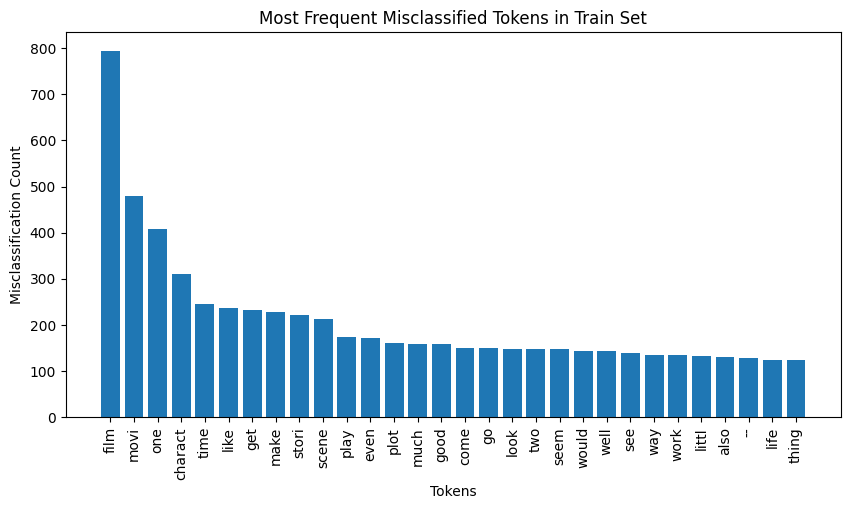

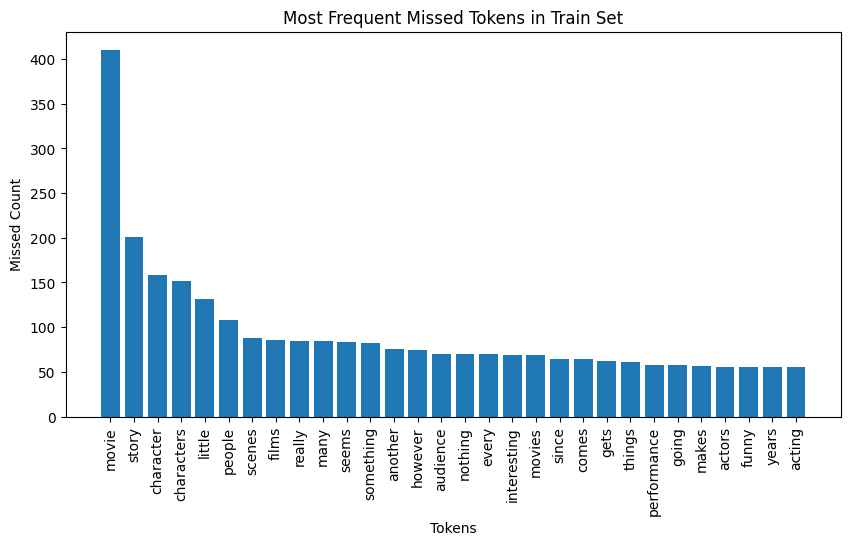


Test Accuracy: 0.7125

Misclassified examples in Test set:
	Tokens: ['as', 'we', 'see', 'the', 'terrible', 'events', 'that', 'unfold', 'before', 'our', 'eyes', 'in', 'the', 'middle', 'east', 'at', 'the', 'moment', ',', 'hollywood', 'doesn', "'", 't', 'loose', 'the', 'oppertunity', 'to', 'get', 'involved', ',', 'by', 'telling', 'stories', 'and', 'expressing', 'opinions', '.', 'this', 'film', 'centers', 'on', 'a', 'relationship', 'forged', 'throughout', 'the', 'adult', 'lifetimes', 'of', 'two', 'marine', 'colonels', ',', 'hays', 'hodges', '(', 'tommy', 'lee', 'jones', ')', 'and', 'terry', 'childers', '(', 'samuel', 'l', '.', 'jackson', ')', '.', 'they', 'fought', 'side', 'by', 'side', 'in', 'vietnam', ',', 'where', 'childers', 'saved', 'hodges', "'", 'life', 'by', 'shooting', 'an', 'unarmed', 'pow', '.', 'that', "'", 's', 'against', 'the', 'rules', 'of', 'war', 'but', 'understandable', ',', 'in', 'this', 'story', 'anyway', ',', 'under', 'the', 'specific', 'circumstances', '.', 'certainl

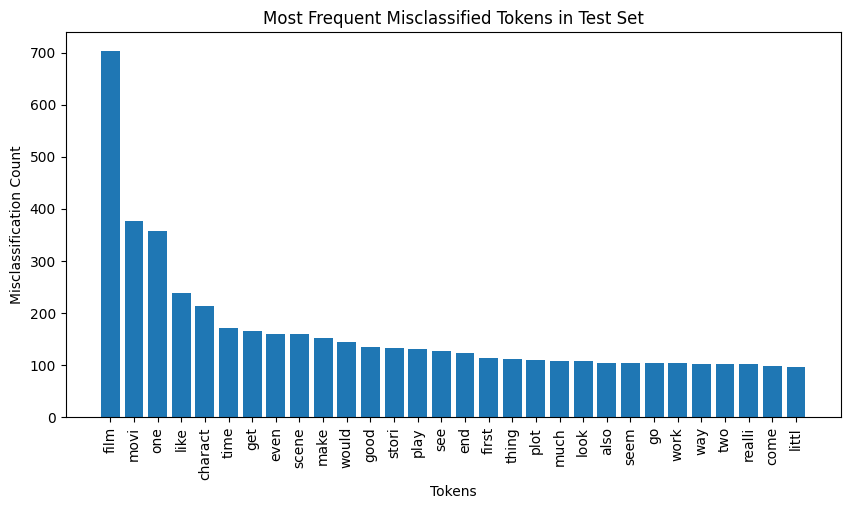

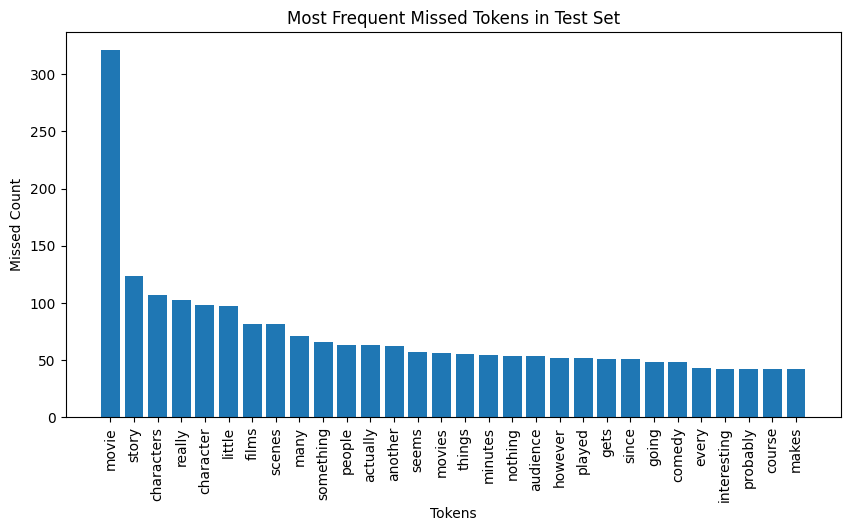

In [28]:
def calculate_accuracy(dataset, dataset_type):
    stop_words = set(stopwords.words('english'))
    correct_predictions = 0
    misclassified_examples = []
    misclassified_tokens = Counter()
    missed_tokens = Counter()

    for example in dataset:
        tokens, true_sentiment = example
        features = get_features(tokens)
        predicted_sentiment = classifier.classify(features)
        if predicted_sentiment == true_sentiment:
            correct_predictions += 1
        else:
            misclassified_examples.append((tokens, true_sentiment, predicted_sentiment))
            misclassified_tokens.update(features)
            missed_tokens.update([token for token in tokens if ((token not in features) and (token.lower() not in stop_words) and (token.lower() not in string.punctuation))])

    accuracy = correct_predictions / len(dataset)
    print(f"{dataset_type} Accuracy: {accuracy}")

    # Print misclassified examples
    print(f"\nMisclassified examples in {dataset_type} set:")
    for tokens, true_sentiment, predicted_sentiment in misclassified_examples[:20]:
        print(f"\tTokens: {tokens}, True Sentiment: {true_sentiment}, Predicted Sentiment: {predicted_sentiment}")
    print()

    print(f"\nMost frequent misclassified tokens in {dataset_type} set:")
    for token, count in misclassified_tokens.most_common()[:30]:
        print(f"\tToken: {token}, Count: {count}")
    print()

    print(f"\nMost frequent misclassified tokens in {dataset_type} set:")
    for token, count in missed_tokens.most_common()[:30]:
        print(f"\tToken: {token}, Count: {count}")
    print()

    # Plot the results
    tokens, counts = zip(*misclassified_tokens.most_common()[:30])
    plot_result(tokens, counts, 'Tokens', 'Misclassification Count', f'Most Frequent Misclassified Tokens in {dataset_type} Set')
    tokens, counts = zip(*missed_tokens.most_common()[:30])
    plot_result(tokens, counts, 'Tokens', 'Missed Count', f'Most Frequent Missed Tokens in {dataset_type} Set')

calculate_accuracy(train_set, 'Train')
calculate_accuracy(test_set, 'Test')

### Analysis and Improvement
The model has predicted positive sentiment for some negative sentiment instances, and vice versa. This discrepancy may be due to the limitations of the naive Bayes algorithm, which assumes independence between features and may not capture complex relationships between them.

With examining the tokens that have been misclassified, we can find out that words and tokens which were kind of neutral were misclassified. for example tokens like: "film" and "movi" or even ones like "--".

Also with examining the examples, we can find that following may have been the reason for the error: sarcasm, negations, word ambiguity, and multipolarity of text.

By comparing most frequent missclassification tokens and missed tokens, we can find out that stemming step has made some of words' spell wrong. For example, story has become stori and also movie has become movi, or really has become realli. So we have made these' spells wrong and perhaps have made our model to have some other words similar to them in the same category.

To improve the process, we can remove stemming and use other lemmatization techniques which may make our model perform better. We also can use the binary naive bayes, which may make the model perform better. We can also use available online datasets, which have provided some words for each positive and negative classes, and so we can count them in and count each occurance of them in our text. All these improvement methods are derived from the resource of NLP course, Jurafsky book.

#Submission Instructions:


1.Submit a Google Colab notebook containing your completed code and experimentation results.

2.Include comments and explanations in your code to help understand the implemented logic.

3.Clearly present the results of your parameter tuning in the notebook.

4.Provide a brief summary of your findings and insights in the conclusion section.

**Additional Notes:**
*   Ensure that the notebook runs successfully in Google Colab.
*   Experiment with various seed texts to showcase the diversity of generated text.
*   Document any issues encountered during experimentation and how you addressed them.

**Grading:**
*   Each task will be graded out of the specified points.
*   Points will be awarded for correctness, clarity of code, thorough experimentation, and insightful analysis.